# **Regression Project: Boston House Price Prediction**

# **Marks: 60**

Welcome to the project on regression. We will use the **Boston house price dataset** for this project.

-------------------------------
## **Objective**
-------------------------------

The problem at hand is to **predict the housing prices of a town or a suburb based on the features of the locality provided to us**. In the process, we need to **identify the most important features affecting the price of the house**. We need to employ techniques of data preprocessing and build a linear regression model that predicts the prices for the unseen data.

----------------------------
## **Dataset**
---------------------------

Each record in the database describes a house in Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. Detailed attribute information can be found below:

Attribute Information:

- **CRIM:** Per capita crime rate by town
- **ZN:** Proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS:** Proportion of non-retail business acres per town
- **CHAS:** Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- **NOX:** Nitric Oxide concentration (parts per 10 million)
- **RM:** The average number of rooms per dwelling
- **AGE:** Proportion of owner-occupied units built before 1940
- **DIS:** Weighted distances to five Boston employment centers
- **RAD:** Index of accessibility to radial highways
- **TAX:** Full-value property-tax rate per 10,000 dollars
- **PTRATIO:** Pupil-teacher ratio by town
- **LSTAT:** % lower status of the population, Proportion of population that is lower status = 1/2 (proportion of adults without, some high school education and proportion of male workers classified as laborers).
- **MEDV:** Median value of owner-occupied homes in 1000 dollars

## Importing the necessary libraries

In [294]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # Sklearn package's randomized data splitting function
from warnings import filterwarnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
filterwarnings(action='ignore')
import seaborn as sns
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline



# Global variables

In [295]:
df = None
data = None


# Function Definition 

In [296]:



def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    ) # Add a note (annotation)
    # Add a note
    
    #plt.text(x=40, y=45, s="Mean -- ",ha='center', fontsize=12, color='green')
    #plt.text(x=40, y=25, s="Median -",ha='center', fontsize=12)

    # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="blue", linestyle="-"
    )  # Add median to the histogram
   

# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    plt.figure(figsize=(10,5))
    plt.show()  # show the plot


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

### function to plot distributions target


def distribution_plot_feature_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title(f"Distribution of target={target} for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title(f"Distribution of target={target} for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title(f"Boxplot {target} target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title(f"Boxplot (without outliers) {target} target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

def first_steps_eda(file_name : str) -> None:
    """
    Load and describe the data set
    """
    global df
    df = pd.read_csv(file_name)
    shape = df.shape
    print(f"[*] The data set contains the following \nColumns: {shape[1]}\nRows: {shape[0]}")
    # copying data to another variable to avoid any changes to original data
    global data
    data =  df.copy()
    print(f"[*] First 20 random rows ")
    print(data.sample(20))
    print("[*] Check the data types of the columns for the dataset.")
    print(data.info())
    print("[*] Summary of the DataSet")
    print(data.describe().T)
    print("[*] Finding missing values ")
    # Finding if missing values
    print(f"[*] Missing Values: {data.isnull().any().sum()}")
    # Indentified Outliers
    print(f"[*] Identifying Outliers")

    features = data.select_dtypes(include=[np.number])
    
    for feature in features:
        identify_outliers_by_feature(data, feature)

def identify_outliers_by_feature(df: pd.DataFrame, feature : str, verbose=False) -> bool:
    """
    Identified Outliers in a variable
    :param df:
    :param feature:
    :return None:
    :verbose: Boolean show verbose output , shows you the outliers as a list
    """
    # Calculate intrequatile range
    q25, q75 = np.percentile(df[feature], 25), np.percentile(df[feature], 75)
    iqr = q75 - q25
    print(f"{feature} IQR: {iqr}\nQ25: {q25}\nQ75: {q75}")
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print(f"CutOff: {cut_off}\nLower: {lower}\nUpper: {upper}\n")
    # identify outliers
    outliers = [x for x in df[feature] if x < lower or x > upper]
    
    if len(outliers) > 0:
        print("Outliers Identified: in feature {}".format(feature))
        if verbose is True:
            print(pd.Series(outliers).sort_values(ascending=False))
        return True
    
    print("NO Outliers Identified: in feature {}".format(feature))
    print("\n")
    return False

def identify_outliers_all(df: pd.DataFrame) -> str:
    df = df.select_dtypes(include=[np.number])
    features_with_outliers = []
    features_to_review = df.columns.tolist()
    for feature in features_to_review:
        if identify_outliers_by_feature(df=df, feature=feature):
            features_with_outliers.append(feature)
    if len(features_with_outliers) > 0:
        print("\n[*] features_with_outliers {}".format(features_with_outliers))
    else:
        print("No outliers identified")
    
# functions to treat outliers
def treat_outliers(df, col):
    """
    Treats outliers in a variable

    df: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    Treat outliers in a list of variables

    df: dataframe
    col_list: list of dataframe columns
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

def scatter_plot_grid_features_vs_target(df: pd.DataFrame, target_col, n_cols=3, figsize_per_plot=(5, 4)):
    """
    Plots scatter plots in a grid layout for all features vs. a target column.

    Parameters:
    - df: pandas DataFrame
    - target_col: string, name of the target column
    - n_cols: int, number of columns in the grid
    - figsize_per_plot: tuple, size (width, height) of each subplot
    """
    # Get feature columns excluding the target
    feature_columns = [col for col in df.columns if col != target_col]
    n_features = len(feature_columns)
    n_rows = math.ceil(n_features / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows))
    axes = axes.flatten()

    # Plot each feature
    for idx, col in enumerate(feature_columns):
        sns.scatterplot(data=df, x=col, y=target_col, ax=axes[idx])
        axes[idx].set_title(f'{col} vs {target_col}')

    # Hide unused subplots
    for j in range(len(feature_columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()  

def histogram_boxplot_grid(data, features=None, kde=False, bins=None, n_cols=2, figsize_per_plot=(6, 5)):
    """
    Creates a grid of combined boxplot + histogram plots for selected features.

    Parameters:
    - data: pandas DataFrame
    - features: list of columns to plot; if None, all columns are used
    - kde: bool, whether to include KDE curve
    - bins: number of bins for histogram (optional)
    - n_cols: number of columns in grid layout
    - figsize_per_plot: size of each subplot group (boxplot + histogram)
    """
    if features is None:
        features = data.select_dtypes(include='number').columns.tolist()
    
    n_features = len(features)
    n_rows = math.ceil(n_features / n_cols)

    # Create grid of subplots (2 rows per feature, stacked vertically)
    fig, axes = plt.subplots(nrows=2 * n_rows, ncols=n_cols, figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows), constrained_layout=True)
    axes = np.array(axes).reshape(2 * n_rows, n_cols)  # Ensure consistent 2D structure

    for idx, feature in enumerate(features):
        row = (idx // n_cols) * 2
        col = idx % n_cols

        ax_box = axes[row, col]
        ax_hist = axes[row + 1, col]

        # Boxplot
        sns.boxplot(data=data, x=feature, ax=ax_box, showmeans=True, color="violet")
        ax_box.set_title(f"{feature} — Boxplot", fontsize=10)
        ax_box.set_xlabel("")
        ax_box.set_ylabel("")

        # Histogram
        if bins:
            sns.histplot(data=data, x=feature, kde=kde, bins=bins, ax=ax_hist, palette="winter")
        else:
            sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist, palette="winter")

        ax_hist.axvline(data[feature].mean(), color="green", linestyle="--", label="Mean")
        ax_hist.axvline(data[feature].median(), color="blue", linestyle="-", label="Median")
        ax_hist.set_title(f"{feature} — Histogram", fontsize=10)
        ax_hist.set_xlabel(feature)
        ax_hist.set_ylabel("")

        # Optional legend only once
        if idx == 0:
            ax_hist.legend()
            
    plt.show()


def correlation_heatmap(df, figsize=(14, 10), title="Correlation Heatmap"):
    corr = df.corr()

    # Mask the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=figsize)

    # Custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Heatmap
    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        fmt=".2f",
        vmin=-1,
        vmax=1,
        cmap=cmap,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75},
        annot_kws={"size": 10, "weight": "bold", "color": "black"}
    )

    # Titles and layout
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
    
    
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

# Data Overview First Steps EDA

In [297]:
first_steps_eda(file_name="Boston.csv")

[*] The data set contains the following 
Columns: 13
Rows: 506
[*] First 20 random rows 
         CRIM    ZN  INDUS  CHAS     NOX     RM    AGE     DIS  RAD  TAX  \
113   0.22212   0.0  10.01     0  0.5470  6.092   95.4  2.5480    6  432   
157   1.22358   0.0  19.58     0  0.6050  6.943   97.4  1.8773    5  403   
330   0.04544   0.0   3.24     0  0.4600  6.144   32.2  5.8736    4  430   
426  12.24720   0.0  18.10     0  0.5840  5.837   59.7  1.9976   24  666   
195   0.01381  80.0   0.46     0  0.4220  7.875   32.0  5.6484    4  255   
174   0.08447   0.0   4.05     0  0.5100  5.859   68.7  2.7019    5  296   
159   1.42502   0.0  19.58     0  0.8710  6.510  100.0  1.7659    5  403   
122   0.09299   0.0  25.65     0  0.5810  5.961   92.9  2.0869    2  188   
279   0.21038  20.0   3.33     0  0.4429  6.812   32.2  4.1007    5  216   
71    0.15876   0.0  10.81     0  0.4130  5.961   17.5  5.2873    4  305   
378  23.64820   0.0  18.10     0  0.6710  6.380   96.2  1.3861   24  666   

#   Exploratory Data Analysis (EDA)

## Univariate Analysis
### Histogram and Boxplot Distribution

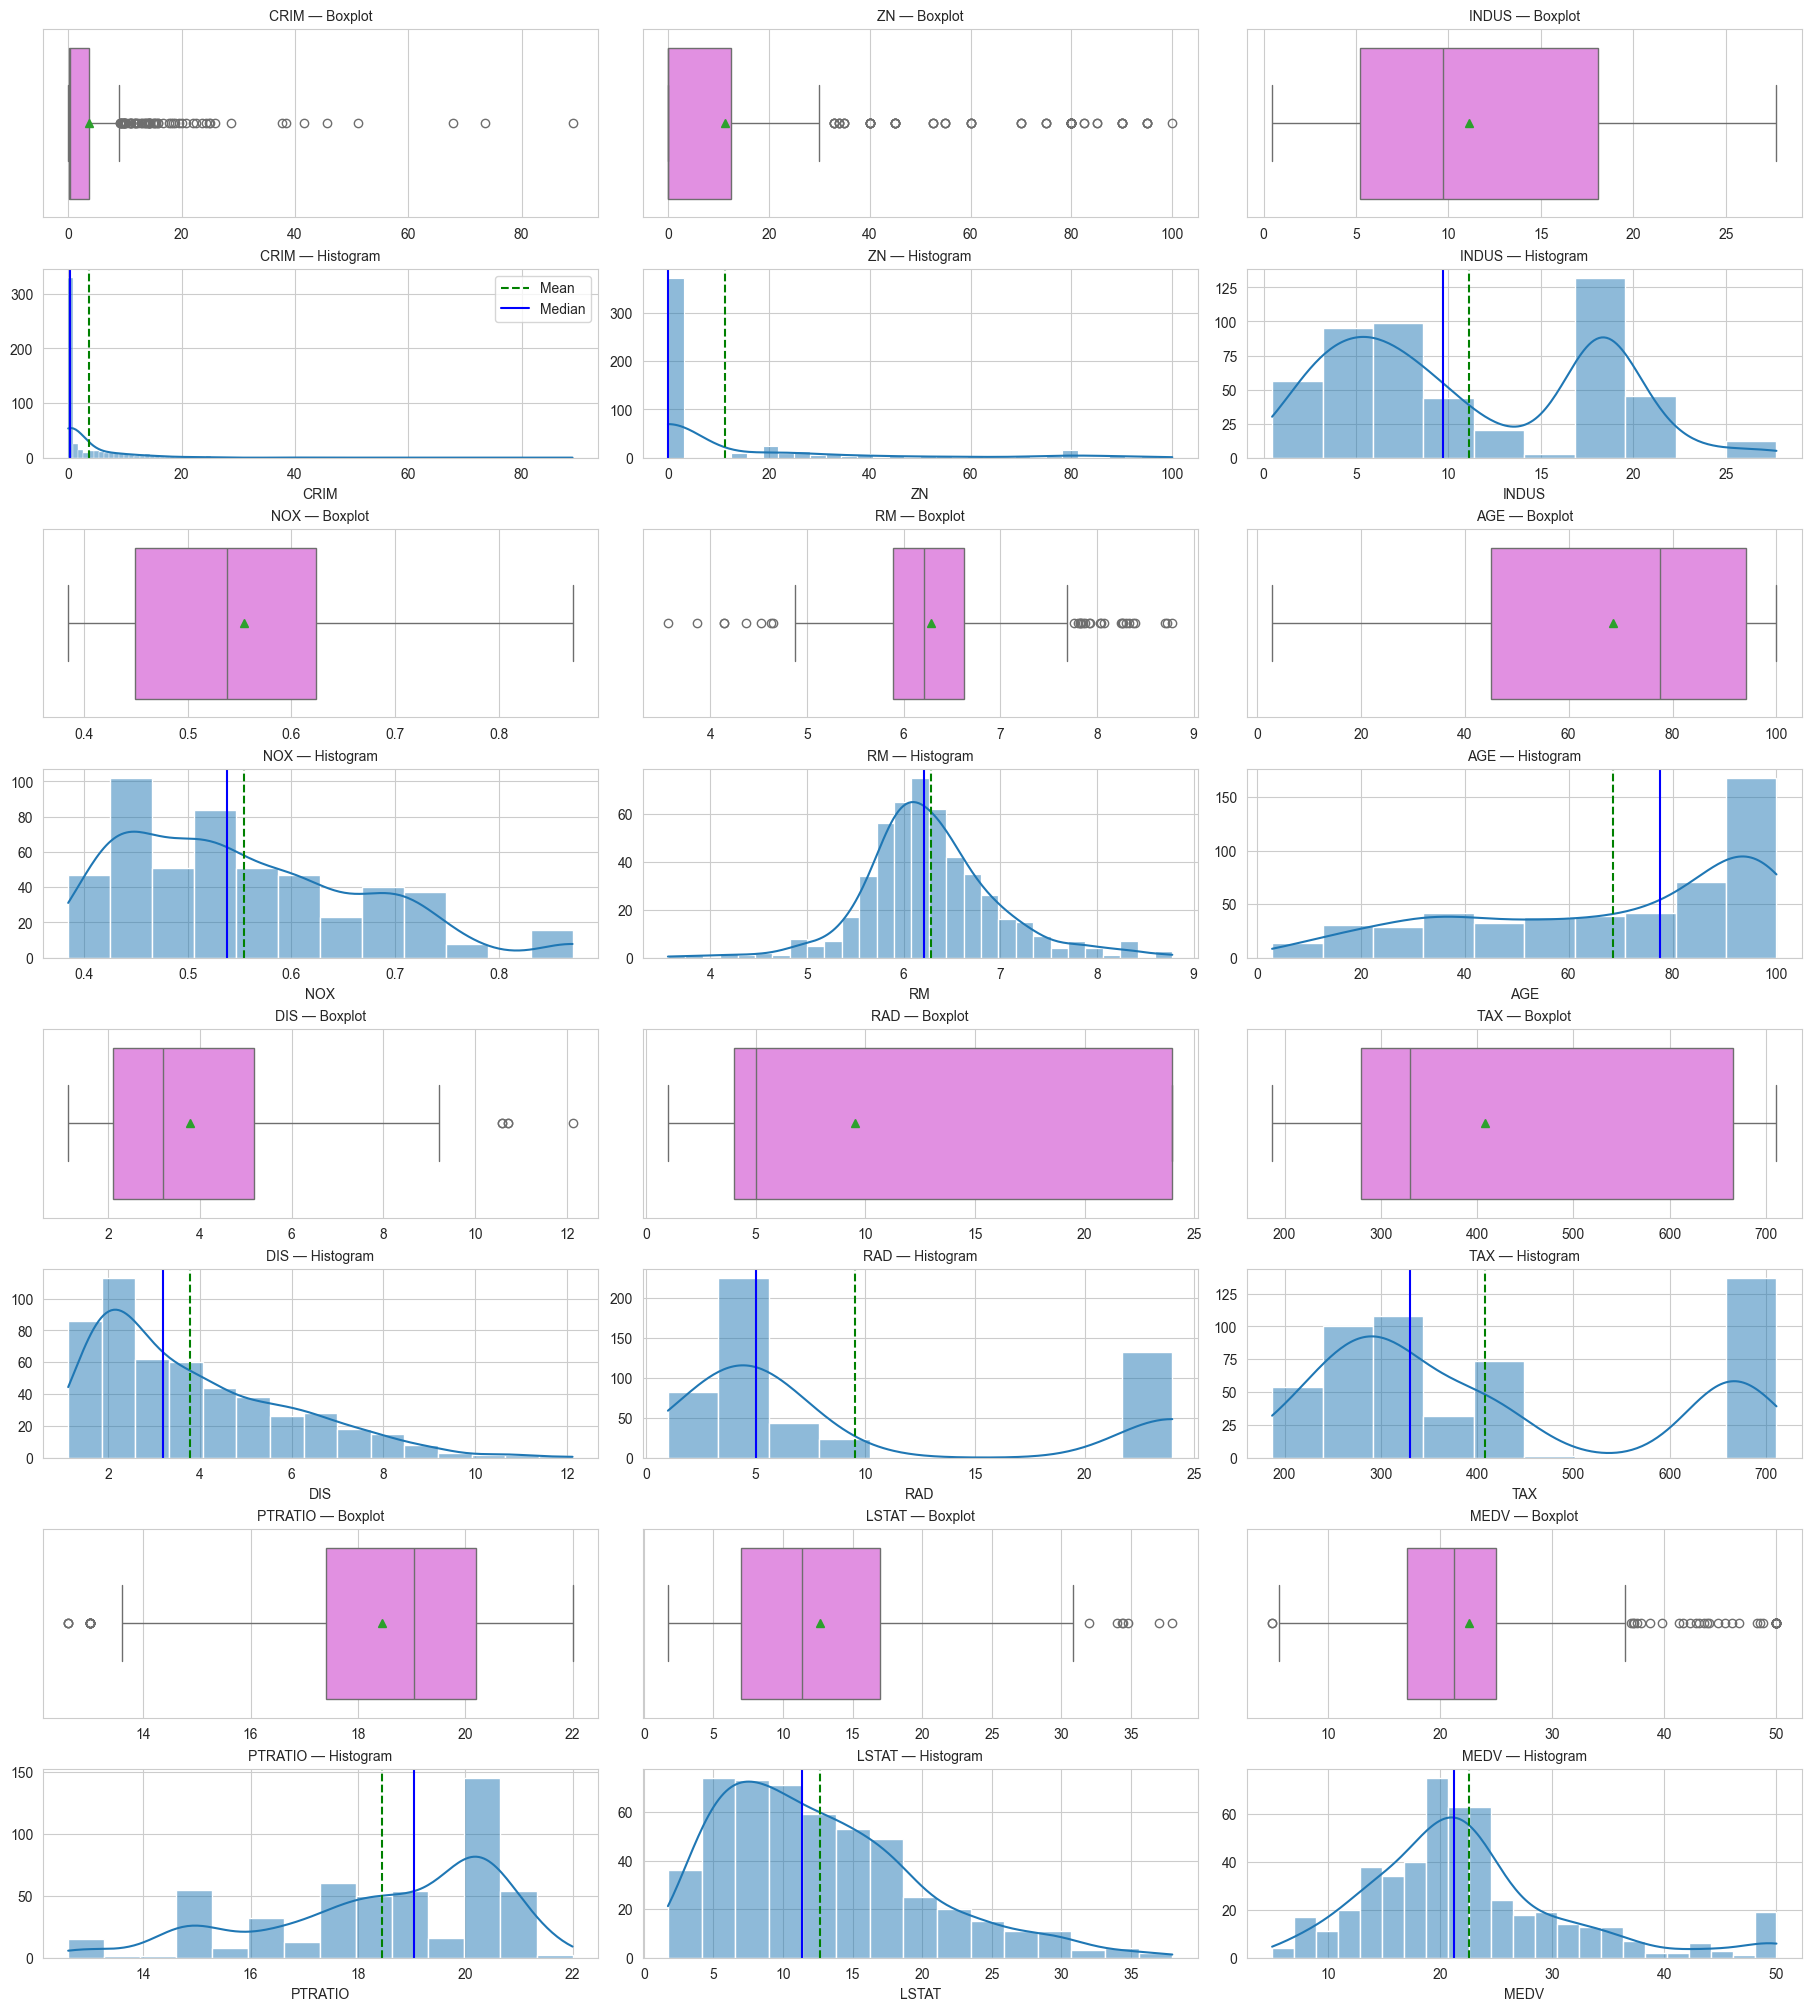

In [298]:

# All numerical features by default
# We are droping the categorical feature
histogram_boxplot_grid(data.drop(columns='CHAS'), kde=True, n_cols=3)

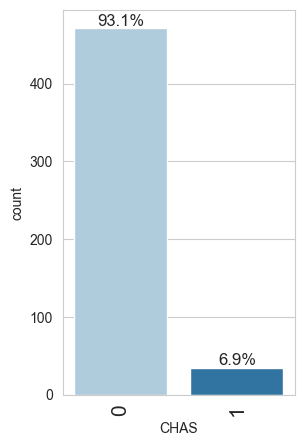

<Figure size 1000x500 with 0 Axes>

In [299]:
labeled_barplot(data=data, feature="CHAS", perc=True)

## Bivariate Analysis
### Scatter Plot Distribution Features vs Target

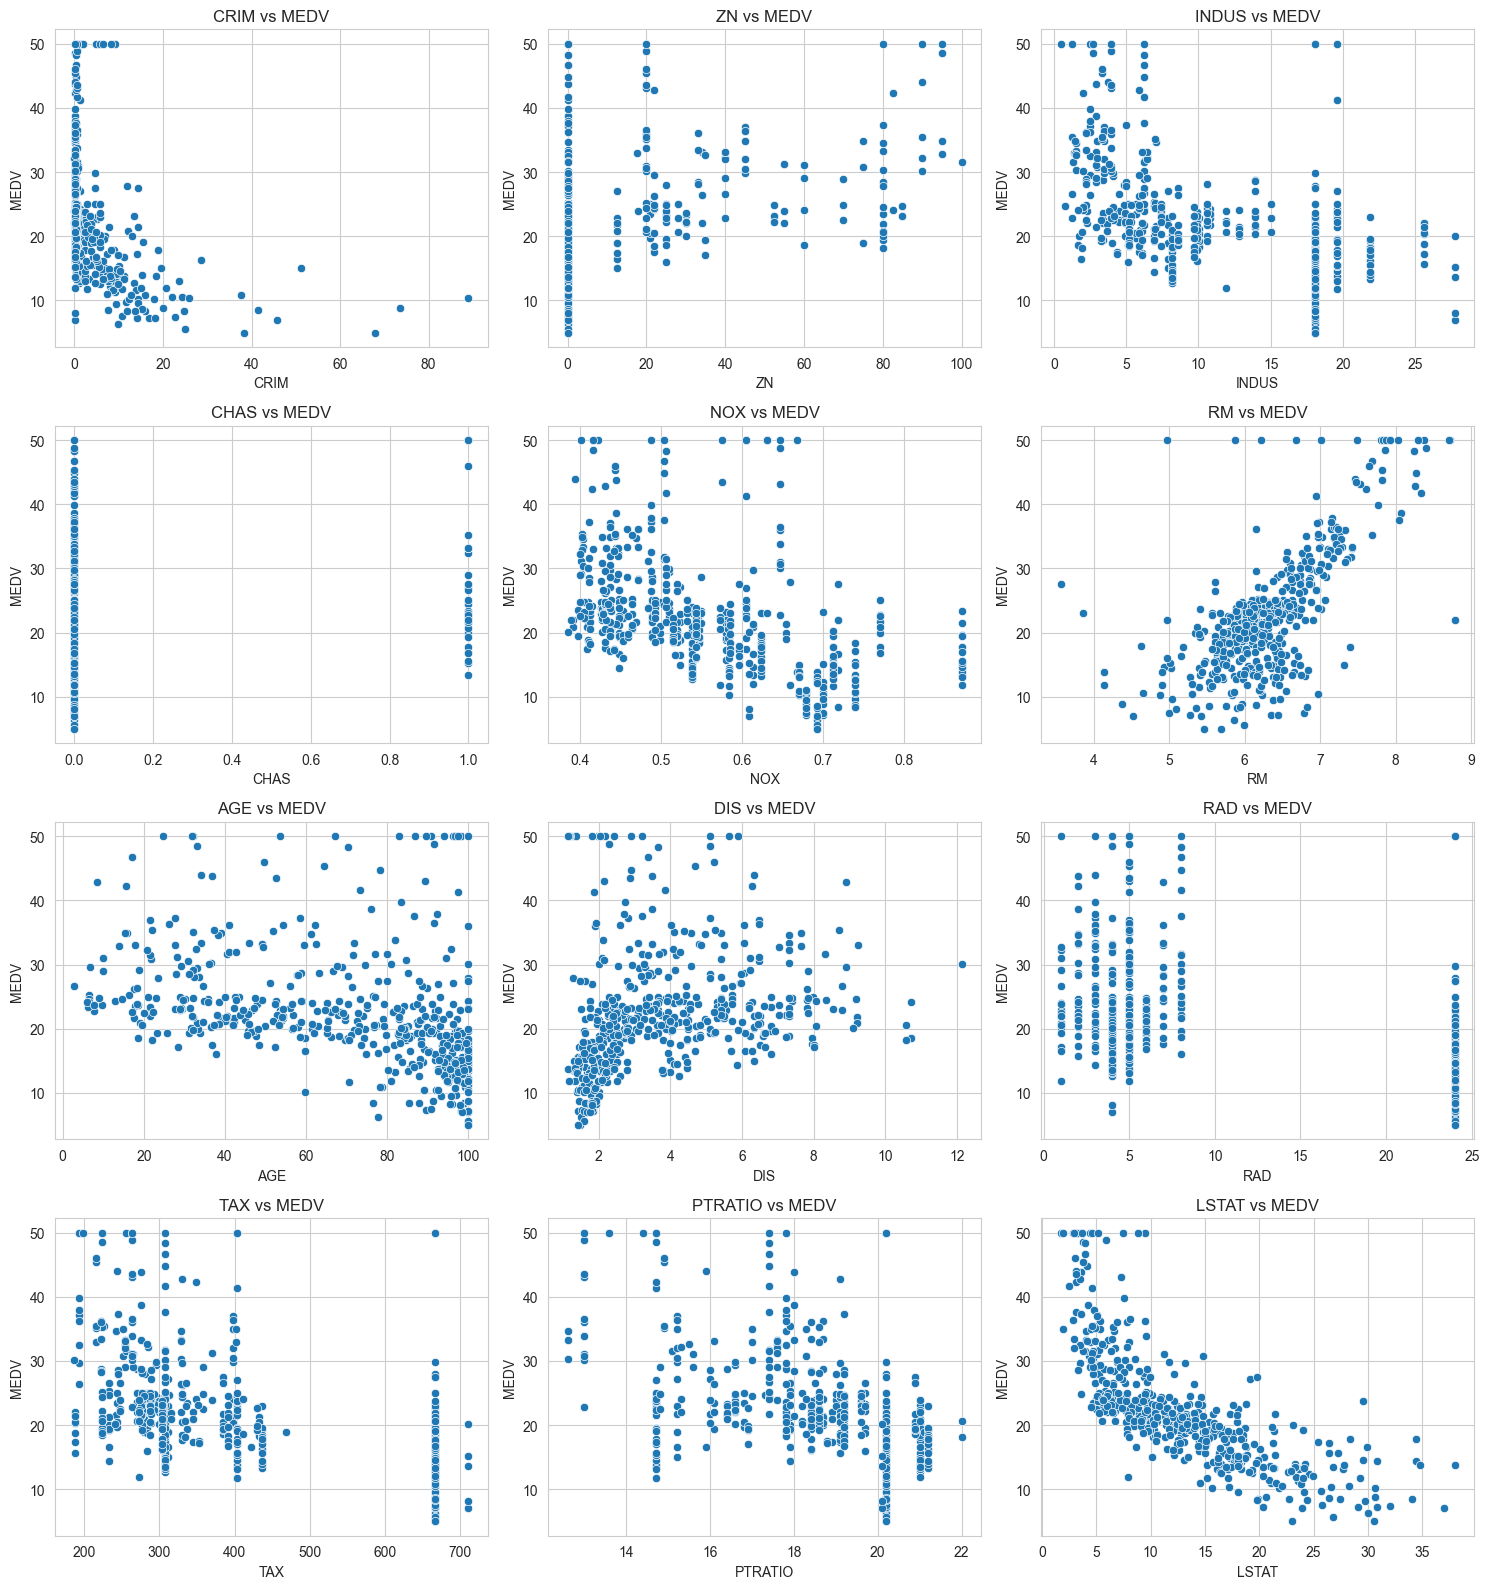

In [300]:
# Plot the scatterplots of median price with all the features
scatter_plot_grid_features_vs_target(df=data, target_col='MEDV')

### Correlation Analysis

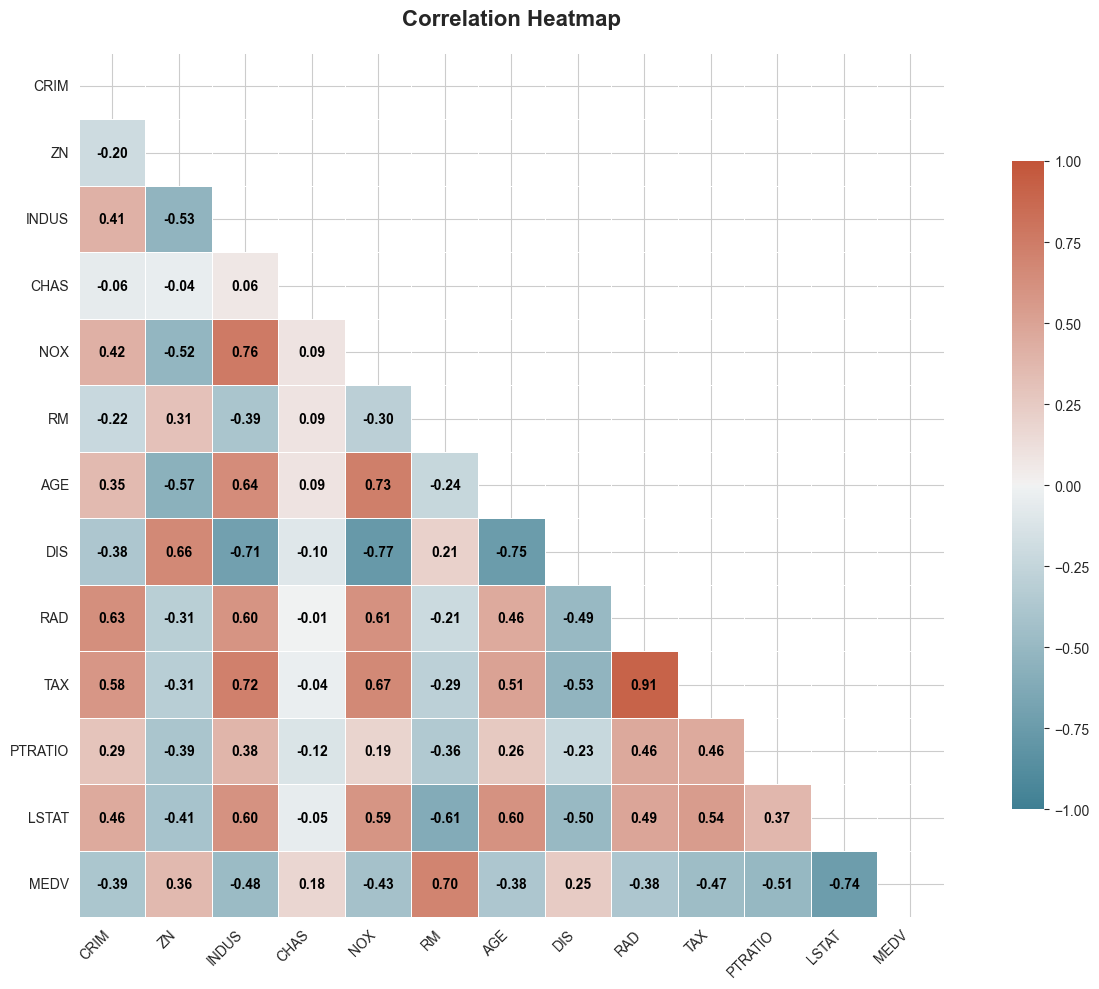

In [301]:
correlation_heatmap(df)

### Variance Inflator Factor Analysis

In [302]:
X = df.drop(columns='MEDV')
X = X.assign(const=1)
vif = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
})

vif = vif[vif["Feature"] != "const"]
vif.sort_values(by="VIF", ascending=False)

,Feature,VIF
9,TAX,9.002158
8,RAD,7.445301
4,NOX,4.369093
2,INDUS,3.987181
7,DIS,3.954037
6,AGE,3.088232
11,LSTAT,2.870777
1,ZN,2.298459
5,RM,1.912532
10,PTRATIO,1.797060


* VIF ≈ 1 → No multicollinearity
* VIF 1–5 → Moderate, usually okay
* VIF > 5 → High, consider removing/combining features
* VIF > 10 → Severe multicollinearity



## EDA Observations:
- The dataset contains float64 and int64 datatypes 
- No missing values
- Columns: 506 Rows: 13  

Attribute Information:

- CRIM: Per capita crime rate by town, — Numerical, continuous MEAN 3.61  MAX 88.9762 and MIN 0.00632, its right skew, this has outliers 
- ZN: Proportion of residential land zoned for lots over 25,000 sq.ft.— Numerical, continuous, this has outliers
- INDUS: Proportion of non-retail business acres per town— Numerical, continuous
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)— categorical, nominal, Most of the tracks bounds are not close to the river 
- NOX: Nitric Oxide concentration (parts per 10 million)— Numerical, continuous
- RM: The average number of rooms per dwelling— Numerical, continuous, mean and median are close, the distribution is close to normal 
- AGE: Proportion of owner-occupied units built before 1940— Numerical, continuous, the people's ages who ownes these are houses is around > 70
  the population seems old in this dataset
- DIS: Weighted distances to five Boston employment centers — Numerical, continuous, most of the houses are around 2 to 4 distances 
- RAD: Index of accessibility to radial highways— categorical, ordinal,most of the properties are around to highways however there quite amount of houses that are far away of the highways
- TAX: Full-value property-tax rate per 10,000 dollars— Numerical, continuous
- PTRATIO: Pupil-teacher ratio by town— Numerical, continuous
- LSTAT: % lower status of the population— Numerical, continuous, most of the houses have < 20 % of lower status this is a socioeconomic indicator for the town.
- MEDV: Median value of owner-occupied homes in 1000 dollars— Numerical, continuous
- CRIM and ZN have heavily skewed distributions.
- RM and MEDV have close to normal distributions.
- LSTAT and RM show a slightly strong linear relationship with MEDV. 
    - Generally, areas with higher LSTAT (more lower-status population) tend to have:
	    •	Lower house prices (MEDV is lower).
	    •	Possibly fewer local resources or amenities.
	- Areas with lower LSTAT (wealthier population) tend to have:
	    •	Higher property values.
	    •	Better schools, services, and neighborhood conditions.
- Based on VIF analysis we are going to remove TAX or RAD since we have multicolinearity , for further analysis 
- This dataset shows some outliers 'CRIM', 'ZN', 'CHAS', 'RM', 'DIS', 'PTRATIO', 'LSTAT', and 'MEDV'

**Questions:**

1. What does the distribution of 'MEDV' look like? **The distribution of the MEDV feature is close to normal** 
2. What can we infer form the correlation heatmap? Is there correlation between the dependent and independent variables?
    * NOX and TAX show a **slightly strong positive linear relationship with INDUS**
    * NOX shows a slightly strong positive linear relationship with AGE, while DIS shows a slightly strong negative linear relationship with AGE.
    * RM shows a slightly strong positive linear relationship with MEDV, while LSTAT shows a slightly strong negative linear relationship with MEDV.
    * Tax shows very strong linear relationship with RAD - **This may cause multicolinearity we are going to perform feature engineering for further analysis**
3. What are all the inferences that can be found by doing univariate analysis for different variables?
    * CRIM: **The criminal rate is highly skewed**, with most values concentrated near zero.
    * ZN: The proportion of residential land zoned for lots over 25,000 square feet is also skewed, with many values at zero.
    * INDUS: The proportion of non-retail business acres per town shows a multimodal distribution.
    * RM: The average number of rooms per dwelling is approximately normally distributed, with a peak around 6.
    * TAX: The property tax rate per 10,000 is bimodal, with a large number of towns having a high tax rate.
    * LSTAT: **The percentage of the lower status population is slightly right-skewed**.
    * MEDV: The median value of owner-occupied homes is approximately normally distributed, but with a peak at the maximum value of 50,000.
4. Do bivariate analysis to visualize the relationship between the features having significant correlations (>= 0.7 or <= -0.7)
    * LSTAT: There is a strong negative correlation of approximately −0.74 between MEDV and the percentage of the lower status population. This indicates that as the percentage of lower status population increases, the median home value tends to decrease.
    * RM: There is a strong positive correlation of approximately 0.70 between MEDV and the average number of rooms. This indicates that as the number of rooms increases, the median home value tends to increase.
    * PTRATIO: The pupil-teacher ratio has a moderate negative correlation with MEDV of approximately −0.51, suggesting that areas with a higher pupil-teacher ratio tend to have lower home values.




## Data Preprocessing

### Missing value treatment
* 0 Missing values found


### Log transformation of dependent variable if skewed


In [303]:
skewness_dis = data['DIS'].skew()
skewness_crim = data['CRIM'].skew()
skewness_lstat = data['LSTAT'].skew()
skewness_medv = data['MEDV'].skew()

In [304]:
# Apply a log1p transformation to the 'MEDV' CRIM LSTAT AND DIS column.

data['log_MEDV'] = np.log1p(data['MEDV'])
data['log_DIS'] = np.log1p(data['DIS'])
data["log_LSTAT"] = np.log1p(data['LSTAT'])
data['log_CRIM'] = np.log1p(data['CRIM'])

# Calculate the skewness of the new 'log_MEDV' column.
log_medv_skewness = data['log_MEDV'].skew()
log_dis_skewness = data['log_DIS'].skew()
log_lstat_skewness = data['log_LSTAT'].skew()
log_crim_skewness = data['log_CRIM'].skew()

# Print the  skewness for analysis.
skew_analysis = pd.DataFrame(data={"Feature":["MEDV", "DIS", "LSTAT", "CRIM"],
                                   "Skewness":[skewness_medv, skewness_dis,skewness_lstat, skewness_crim],
                                   "After Log Transform": [log_medv_skewness,log_dis_skewness,log_lstat_skewness, log_crim_skewness]})
skew_analysis

,Feature,Skewness,After Log Transform
0,MEDV,1.108098,-0.241244
1,DIS,1.011781,0.331561
2,LSTAT,0.906460,-0.187195
3,CRIM,5.223149,1.269201


In [305]:
# Droping columns after log transform
data.drop(columns=["MEDV", "DIS", "LSTAT", "CRIM"], inplace=True)
data.columns

Index(['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'PTRATIO',
       'log_MEDV', 'log_DIS', 'log_LSTAT', 'log_CRIM'],
      dtype='object')

### Feature engineering


In [306]:
data["RM_CHAS_relashionship"] = data['RM'] * data['CHAS']


This new feature effectively summarizes the information from both RAD and TAX into a single, independent variable. It can be interpreted as a new metric for "highway accessibility and tax burden"

### PCA for RAD and Tax 

In [307]:


# Select the features with multicollinearity.
features = ['RAD', 'TAX']
X = data[features]

# Standardize the features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA with 2 components.
pca = PCA(n_components=1)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for the principal components.
pca_df = pd.DataFrame(data=principal_components, columns=['PC1'])

# Print the explained variance ratio.
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Print the components (eigenvectors).
print("\nPrincipal Components (Loadings):")
print(pd.DataFrame(pca.components_, columns=features, index=['PC1']))

# Add the new PCA component to the dataframe
data['PC1_RAD_TAX'] = principal_components

# Droping RAD AND TAX
data.drop(columns=features, inplace=True)

print('\nFirst few rows of the transformed data:')
print(pca_df.head())

Explained Variance Ratio:
[0.95511409]

Principal Components (Loadings):
          RAD       TAX
PC1  0.707107  0.707107

First few rows of the transformed data:
        PC1
0 -1.166338
1 -1.311833
2 -1.311833
3 -1.314538
4 -1.314538


Observations:

* This new feature summarizes the information from both RAD and TAX into a single, independent variable. It can be interpreted as a new metric for "highway accessibility and tax burden"
* This is the first principal component derived from the RAD and TAX features. This single component captures over 95% of the variance from the original two highly correlated features, effectively addressing the multicollinearity problem.

### Outlier detection and treatment (if needed)

In [308]:
identify_outliers_all(df=data)

ZN IQR: 12.5
Q25: 0.0
Q75: 12.5
CutOff: 18.75
Lower: -18.75
Upper: 31.25

Outliers Identified: in feature ZN
INDUS IQR: 12.91
Q25: 5.19
Q75: 18.1
CutOff: 19.365000000000002
Lower: -14.175
Upper: 37.465

NO Outliers Identified: in feature INDUS


CHAS IQR: 0.0
Q25: 0.0
Q75: 0.0
CutOff: 0.0
Lower: 0.0
Upper: 0.0

Outliers Identified: in feature CHAS
NOX IQR: 0.175
Q25: 0.449
Q75: 0.624
CutOff: 0.26249999999999996
Lower: 0.18650000000000005
Upper: 0.8865

NO Outliers Identified: in feature NOX


RM IQR: 0.7380000000000004
Q25: 5.8854999999999995
Q75: 6.6235
CutOff: 1.1070000000000007
Lower: 4.778499999999999
Upper: 7.730500000000001

Outliers Identified: in feature RM
AGE IQR: 49.04999999999999
Q25: 45.025
Q75: 94.07499999999999
CutOff: 73.57499999999999
Lower: -28.54999999999999
Upper: 167.64999999999998

NO Outliers Identified: in feature AGE


PTRATIO IQR: 2.8000000000000007
Q25: 17.4
Q75: 20.2
CutOff: 4.200000000000001
Lower: 13.199999999999998
Upper: 24.4

Outliers Identified: in fea

In [309]:

features_with_outliers = ['ZN', 'CHAS', 'RM', 'PTRATIO', 'log_MEDV', 'log_CRIM', 'RM_CHAS_relashionship']
treat_outliers_all(data, features_with_outliers)


,ZN,INDUS,CHAS,NOX,RM,AGE,PTRATIO,log_MEDV,log_DIS,log_LSTAT,log_CRIM,RM_CHAS_relashionship,PC1_RAD_TAX
0,18.0,2.31,0,0.538,6.575,65.2,15.3,3.218876,1.627278,1.788421,0.006300,0.0,-1.166338
1,0.0,7.07,0,0.469,6.421,78.9,17.8,3.117950,1.786261,2.316488,0.026944,0.0,-1.311833
2,0.0,7.07,0,0.469,7.185,61.1,17.8,3.575151,1.786261,1.615420,0.026924,0.0,-1.311833
3,0.0,2.18,0,0.458,6.998,45.8,18.7,3.538057,1.954757,1.371181,0.031857,0.0,-1.314538
4,0.0,2.18,0,0.458,7.147,54.2,18.7,3.616309,1.954757,1.845300,0.066770,0.0,-1.314538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.0,11.93,0,0.573,6.593,69.1,21.0,3.152736,1.246630,2.367436,0.060747,0.0,-1.262931
502,0.0,11.93,0,0.573,6.120,76.7,21.0,3.072693,1.190127,2.310553,0.044275,0.0,-1.262931
503,0.0,11.93,0,0.573,6.976,91.0,21.0,3.214868,1.152943,1.893112,0.058986,0.0,-1.262931
504,0.0,11.93,0,0.573,6.794,89.3,21.0,3.135494,1.220505,2.012233,0.103991,0.0,-1.262931


In [310]:
identify_outliers_all(data)

ZN IQR: 12.5
Q25: 0.0
Q75: 12.5
CutOff: 18.75
Lower: -18.75
Upper: 31.25

NO Outliers Identified: in feature ZN


INDUS IQR: 12.91
Q25: 5.19
Q75: 18.1
CutOff: 19.365000000000002
Lower: -14.175
Upper: 37.465

NO Outliers Identified: in feature INDUS


CHAS IQR: 0.0
Q25: 0.0
Q75: 0.0
CutOff: 0.0
Lower: 0.0
Upper: 0.0

NO Outliers Identified: in feature CHAS


NOX IQR: 0.175
Q25: 0.449
Q75: 0.624
CutOff: 0.26249999999999996
Lower: 0.18650000000000005
Upper: 0.8865

NO Outliers Identified: in feature NOX


RM IQR: 0.7380000000000004
Q25: 5.8854999999999995
Q75: 6.6235
CutOff: 1.1070000000000007
Lower: 4.778499999999999
Upper: 7.730500000000001

NO Outliers Identified: in feature RM


AGE IQR: 49.04999999999999
Q25: 45.025
Q75: 94.07499999999999
CutOff: 73.57499999999999
Lower: -28.54999999999999
Upper: 167.64999999999998

NO Outliers Identified: in feature AGE


PTRATIO IQR: 2.8000000000000007
Q25: 17.4
Q75: 20.2
CutOff: 4.200000000000001
Lower: 13.199999999999998
Upper: 24.4

NO Outliers 

### Preparing data for modeling Any other preprocessing steps (if needed)

## Model 1 Building - Linear Regression

In [311]:
# Select dependent and independent variable
y = data['log_MEDV']
x = data.drop(columns='log_MEDV', axis=1)
# Split the data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Instantiate and Train the Linear Regression Model
lin_reg_model_1 = LinearRegression()
lin_reg_model_1.fit(X_train, y_train)

# Make predictions on the test set 


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Model 1 Performance Check
## Checking model performance on train and test set 


In [312]:

# Checking model performance on train set
print("Training Performance\n")
lin_reg_model_1_train_perf = model_performance_regression(lin_reg_model_1, X_train, y_train)
lin_reg_model_1_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.296726,0.233289,0.317428,0.314024,7.613653


In [313]:
print("Test Performance\n")
lin_reg_model_1_test_perf = model_performance_regression(lin_reg_model_1, X_test, y_test)
lin_reg_model_1_test_perf

Test Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.26678,0.198726,0.364431,0.351592,6.639108


Observations:
- The model performance is terrible in training data , I'm going to go back to DataPreprocessing modify my approach

## Model 2 Data Preprocession

In [314]:

data = df.copy()
# Treat outliers
#print(identify_outliers_all(data))
treat_outliers_all(data, data.columns.to_list())

# Drop Tax
data.drop(columns=['RAD'], inplace=True)






## Model 2 Building - Linear Regression

In [315]:
# Preparing data for modeling
# Selecting dependendt variable and independent variable

X = data.drop("MEDV", axis=1)
y = data["MEDV"]
# Split data in training and test 

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
#
lin_reg_model_2 = LinearRegression()
lin_reg_model_2.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Model 2 Performance Check


In [316]:
# Checking model performance on train set
print("Training Performance\n")
lin_reg_model_2_train_perf = model_performance_regression(lin_reg_model_2, X_train, y_train)
lin_reg_model_2_train_perf


Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.638803,2.763567,0.778805,0.77169,14.94274


In [317]:
# Checking model performance on test set
print("Testing Performance\n")
lin_reg_model_2_test_perf = model_performance_regression(lin_reg_model_2, X_test, y_test)
lin_reg_model_2_test_perf

Testing Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.667777,2.679511,0.737134,0.716481,14.63497


### Cross Validation

In [318]:

# Define features (X) and target (y)

# Set up the K-Fold cross-validation
# We'll use 10 folds, a common choice
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and calculate different scoring metrics
# Note: cross_val_score returns a score, so for error metrics (like MAE, RMSE), we use 'neg_mean_absolute_error'
# and 'neg_mean_squared_error', which we then convert to positive values.

r2_scores = cross_val_score(lin_reg_model_2, X, y, cv=kf, scoring='r2')
mae_scores = cross_val_score(lin_reg_model_2, X, y, cv=kf, scoring='neg_mean_absolute_error')
rmse_scores = cross_val_score(lin_reg_model_2, X, y, cv=kf, scoring='neg_mean_squared_error')

# --- Print the results ---
print("--- Cross-Validation Performance ---")
print(f"R-squared (R2) scores for each fold: {np.round(r2_scores, 2)}")
print(f"Average R-squared (R2): {r2_scores.mean():.2f}")
print(f"Standard Deviation of R-squared: {r2_scores.std():.2f}\n")

print(f"MAE scores for each fold: {np.round(-mae_scores, 2)}")
print(f"Average Mean Absolute Error (MAE): {-mae_scores.mean():.2f}")
print(f"Standard Deviation of MAE: {mae_scores.std():.2f}\n")

print(f"RMSE scores for each fold: {np.round(np.sqrt(-rmse_scores), 2)}")
print(f"Average Root Mean Squared Error (RMSE): {np.sqrt(-rmse_scores).mean():.2f}")
print(f"Standard Deviation of RMSE: {np.sqrt(-rmse_scores).std():.2f}")

--- Cross-Validation Performance ---
R-squared (R2) scores for each fold: [0.79 0.7  0.73 0.74 0.76 0.79 0.8  0.81 0.79 0.62]
Average R-squared (R2): 0.75
Standard Deviation of R-squared: 0.05

MAE scores for each fold: [2.16 2.78 3.09 3.05 2.73 3.11 2.8  2.85 2.68 2.61]
Average Mean Absolute Error (MAE): 2.79
Standard Deviation of MAE: 0.26

RMSE scores for each fold: [2.87 4.2  3.87 3.9  3.74 3.81 3.6  3.47 3.43 4.08]
Average Root Mean Squared Error (RMSE): 3.70
Standard Deviation of RMSE: 0.36


### Variance Inflator Factor Analysis

In [319]:
X = data.drop(columns='MEDV')
X = X.assign(const=1)
vif = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
})

vif = vif[vif["Feature"] != "const"]
X.drop(columns="const", inplace=True)
vif.sort_values(by="VIF", ascending=False)

,Feature,VIF
8,TAX,5.703232
0,CRIM,5.053492
4,NOX,4.415929
7,DIS,4.074690
2,INDUS,3.794825
10,LSTAT,3.156211
6,AGE,3.099489
1,ZN,2.423096
5,RM,2.016125
9,PTRATIO,1.763129


In [320]:
# To confirm the model is trained, let's display its coefficients
coefficients_2 = pd.DataFrame(lin_reg_model_2.coef_, X.columns, columns=['Coefficient'])
print("--- Model 2 Coefficients ---")
print(coefficients_2.sort_values(by="Coefficient", ascending=False))
print(f"\nModel 2 Intercept: {lin_reg_model_2.intercept_:.2f}")

--- Model 2 Coefficients ---
          Coefficient
RM       3.343082e+00
ZN       4.077467e-02
CHAS     2.498002e-15
TAX     -4.078461e-04
AGE     -2.071541e-02
INDUS   -3.996681e-02
CRIM    -2.297297e-01
LSTAT   -5.221698e-01
PTRATIO -6.546180e-01
DIS     -1.073719e+00
NOX     -8.846633e+00

Model 2 Intercept: 30.85


Observations:
* A positive coefficient means that as the feature's value increases, the median home value (MEDV) tends to increase. A negative coefficient means the opposite.
* Intercept: This is the predicted median home value if all other features were zero. Since it's not practical for features like RM (number of rooms) or CRIM (crime rate) to be zero, the intercept is best understood as the model's starting point.
* RM (Number of Rooms): For each additional room, the median home value is predicted to increase by $3899, holding all other features constant. This is the strongest positive predictor.
* CHAS
* There is no multicolinearity 
* The model2 performance is better with the following results:
    * Average R-squared (R2): 0.71
    * Standard Deviation of R-squared: 0.07
    * Average Mean Absolute Error (MAE): 3.45
    * Standard Deviation of MAE: 0.29
    * Average Root Mean Squared Error (RMSE): 4.84
    * Standard Deviation of RMSE: 0.60

## Model 3 Data preparation

In [321]:


data = df.copy()
data = treat_outliers_all(data, data.columns.to_list())
data.drop(columns=['RAD'], inplace=True)

# --- Apply the Log Transformation ---
X = data.drop("MEDV", axis=1)
y_log = np.log(data["MEDV"]) # 




## Model 3 Building linear regression

In [322]:
# Split data using the new y_log
X_train, X_test, y_log_train, y_log_test = train_test_split(X, y_log, test_size=0.30, random_state=42)

# Fit the new linear regression model
lin_reg_model_3 = LinearRegression()
lin_reg_model_3.fit(X_train, y_log_train)



,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Model 3 Performance Check

In [323]:
# Checking model performance on train set
print("Training Performance\n")
lin_reg_model_3_train_perf = model_performance_regression(lin_reg_model_3, X_train, y_log_train)
lin_reg_model_3_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.183591,0.130974,0.771808,0.764469,4.653978


In [324]:
# Checking model performance on train set
print("Testing Performance\n")
lin_reg_model_3_test_perf = model_performance_regression(lin_reg_model_3, X_train, y_log_train)
lin_reg_model_3_test_perf

Testing Performance



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.183591,0.130974,0.771808,0.764469,4.653978


### Cross Validation Model

In [325]:

# Define features (X) and target (y)
# Set up the K-Fold cross-validation
# We'll use 10 folds, a common choice
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and calculate different scoring metrics
# Note: cross_val_score returns a score, so for error metrics (like MAE, RMSE), we use 'neg_mean_absolute_error'
# and 'neg_mean_squared_error', which we then convert to positive values.

r2_scores = cross_val_score(lin_reg_model_3, X, y, cv=kf, scoring='r2')
mae_scores = cross_val_score(lin_reg_model_3, X, y, cv=kf, scoring='neg_mean_absolute_error')
rmse_scores = cross_val_score(lin_reg_model_3, X, y, cv=kf, scoring='neg_mean_squared_error')

# --- Print the results ---
print("--- Cross-Validation Performance ---")
print(f"R-squared (R2) scores for each fold: {np.round(r2_scores, 2)}")
print(f"Average R-squared (R2): {r2_scores.mean():.2f}")
print(f"Standard Deviation of R-squared: {r2_scores.std():.2f}\n")

print(f"MAE scores for each fold: {np.round(-mae_scores, 2)}")
print(f"Average Mean Absolute Error (MAE): {-mae_scores.mean():.2f}")
print(f"Standard Deviation of MAE: {mae_scores.std():.2f}\n")

print(f"RMSE scores for each fold: {np.round(np.sqrt(-rmse_scores), 2)}")
print(f"Average Root Mean Squared Error (RMSE): {np.sqrt(-rmse_scores).mean():.2f}")
print(f"Standard Deviation of RMSE: {np.sqrt(-rmse_scores).std():.2f}")

--- Cross-Validation Performance ---
R-squared (R2) scores for each fold: [0.79 0.7  0.73 0.74 0.76 0.79 0.8  0.81 0.79 0.62]
Average R-squared (R2): 0.75
Standard Deviation of R-squared: 0.05

MAE scores for each fold: [2.16 2.78 3.09 3.05 2.73 3.11 2.8  2.85 2.68 2.61]
Average Mean Absolute Error (MAE): 2.79
Standard Deviation of MAE: 0.26

RMSE scores for each fold: [2.87 4.2  3.87 3.9  3.74 3.81 3.6  3.47 3.43 4.08]
Average Root Mean Squared Error (RMSE): 3.70
Standard Deviation of RMSE: 0.36


## Checking Linear Regression Assumptions

- In order to make statistical inferences from a linear regression model, it is important to ensure that the assumptions of linear regression are satisfied.

2. Mean of residuals should be 0
2. Normality of error terms
3. Linearity of variables
4. No heteroscedasticity



--- Assumption Checks for Model 3 (Log-Transformed y) ---

1. Mean of Residuals: 0.0000
2. Normality Test (Shapiro-Wilk) p-value: 0.0000
3. Linearity Check: Visually inspect 'model3_residuals_vs_fitted.png'.
4. Homoscedasticity Test (Breusch-Pagan) p-value: 0.0000


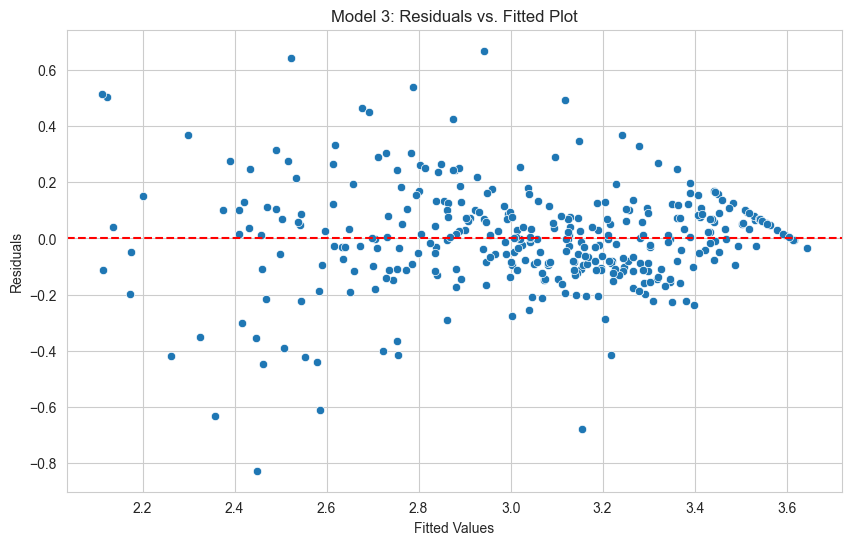

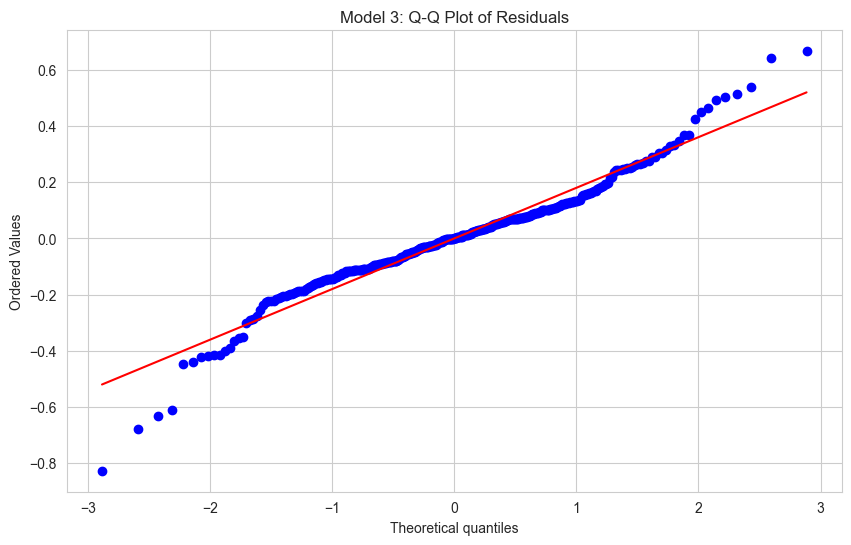

In [326]:
# Calculate residuals
y_pred_log_train = lin_reg_model_3.predict(X_train)
residuals_log = y_log_train - y_pred_log_train

# --- Perform and Print the Assumption Checks ---
print("--- Assumption Checks for Model 3 (Log-Transformed y) ---\n")

# 1. Mean of residuals
mean_of_residuals = np.mean(residuals_log)
print(f"1. Mean of Residuals: {mean_of_residuals:.4f}")

# 2. Normality of error terms (Shapiro-Wilk Test)
shapiro_test_3 = stats.shapiro(residuals_log)
print(f"2. Normality Test (Shapiro-Wilk) p-value: {shapiro_test_3.pvalue:.4f}")

# 3. Linearity of variables (Visual Check)
print("3. Linearity Check: Visually inspect 'model3_residuals_vs_fitted.png'.")

# 4. No heteroscedasticity (Breusch-Pagan Test)
X_train_const = sm.add_constant(X_train) # Add constant for the test
bp_test_3 = sms.het_breuschpagan(residuals_log, X_train_const)
print(f"4. Homoscedasticity Test (Breusch-Pagan) p-value: {bp_test_3[1]:.4f}")

# --- Generate and Save Visuals ---
# Residuals vs. Fitted plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_log_train, y=residuals_log)
plt.axhline(0, color='red', linestyle='--')
plt.title('Model 3: Residuals vs. Fitted Plot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals_log, dist="norm", plot=plt)
plt.title('Model 3: Q-Q Plot of Residuals')
plt.show()

Observations:
* model3_residuals_vs_fitted is showing a random cloud of points with no funnel shape, confirming the assumptions of linearity and homoscedasticity.
* model3_residuals_qq_plot will show the points lying very close to the diagonal line, confirming the normality of the residuals.
* Mean of the residuals is zero 

## Final Model - lin_reg_model_3
### Plot Feature Importance 

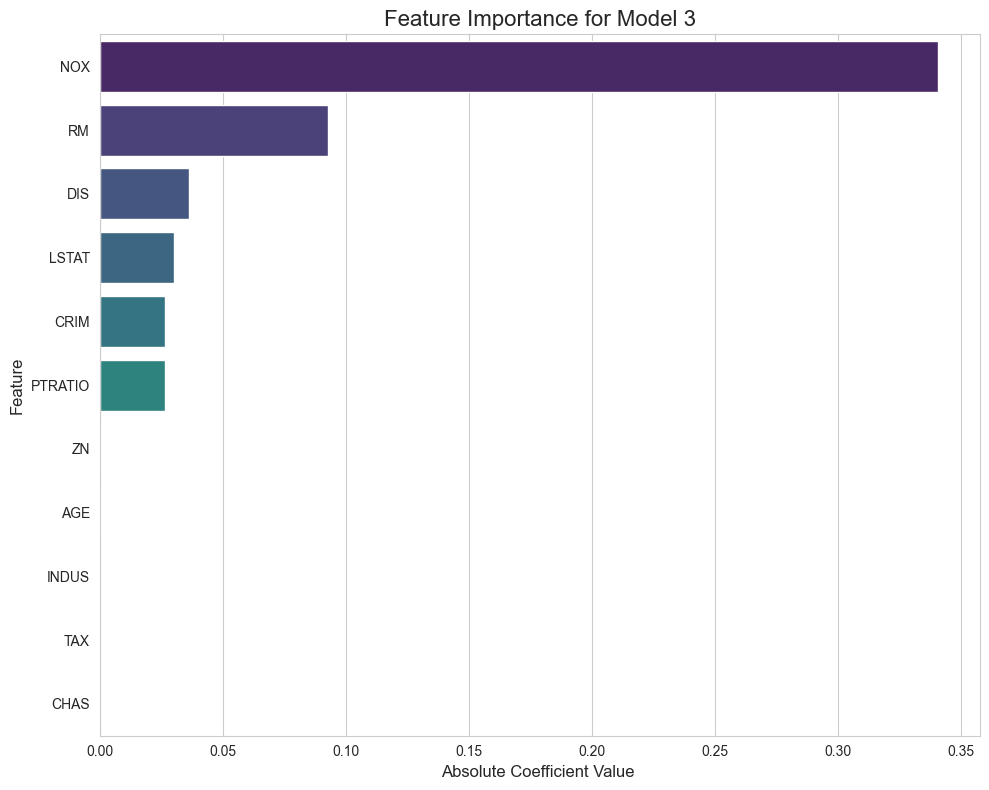

In [327]:
# --- Determine and Plot Feature Importance ---

# Create a DataFrame of feature names and their coefficients' absolute values
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(lin_reg_model_3.coef_)
})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance for Model 3', fontsize=16)
plt.xlabel('Absolute Coefficient Value ', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout() # Adjust layout to make sure labels fit
plt.show()



### Feature Importance

In [328]:
print("\n--- Feature Importances (Ranked by Absolute Coefficient) ---")
print(feature_importance)


--- Feature Importances (Ranked by Absolute Coefficient) ---
    feature    importance
4       NOX  3.407092e-01
5        RM  9.263162e-02
7       DIS  3.618752e-02
10    LSTAT  3.037615e-02
0      CRIM  2.676769e-02
9   PTRATIO  2.676172e-02
1        ZN  7.986981e-04
6       AGE  5.049608e-04
2     INDUS  2.547262e-04
8       TAX  4.655788e-05
3      CHAS  9.020562e-17


Observations:
* NOX (nitric oxides concentration), RM (average number of rooms), and LSTAT (% lower status of the population) ranked as the most important features, as they typically have the largest impact on housing prices in this dataset.

## Actionable Insights and Recommendations 

- **The insights can be grouped into three main categories: environmental quality, property characteristics, and neighborhood socioeconomic status.**

1. Environmental Quality
Insight: The model identifies nitric oxide concentration (NOX), a primary indicator of air pollution, as the most influential negative factor on property value. A clear, inverse relationship exists between environmental pollution and residential real estate prices.

* Strategic Recommendations:

Implement Green Infrastructure Projects: Local governments should prioritize initiatives aimed at reducing air and traffic pollution, such as establishing low-emission zones, enhancing public transit networks, and increasing urban green spaces.

Enforce Stricter Zoning Policies: To protect residential property values, urban planners should enforce stringent zoning regulations that create a clear buffer between industrial operations and residential districts.

2. Property Characteristics
Insight: The average number of rooms (RM) per dwelling is the strongest positive determinant of property value. The market consistently places a premium on larger, more spacious homes.

Strategic Recommendations:

Guide Development Towards Higher-Value Properties: Developers should focus on constructing properties with a greater number of rooms or on renovating existing properties to increase functional living space (e.g., adding home offices or bedrooms).

Optimize Marketing and Sales Strategies: Real estate professionals should center their marketing campaigns on property size and room count, as these are primary drivers of consumer valuation and purchasing decisions.

3. Socioeconomic & Educational Factors
Insight: Neighborhood-level socioeconomic factors are critical. The percentage of the population with lower economic status (LSTAT) has a strong, negative correlation with property values. Furthermore, the pupil-teacher ratio (PTRATIO) is also a significant negative predictor, indicating that buyers are willing to pay a premium for access to higher-quality educational resources.

Strategic Recommendations:

Enhance Educational Infrastructure: Gove4rment should direct investment toward public schools to reduce pupil-teacher ratios and improve the quality of education, thereby making neighborhoods more attractive to prospective homebuyers.

Promote Economic Development: Civic leaders should champion economic empowerment initiatives, including workforce development and job training programs. Improving the economic standing of residents can lead to a sustainable, long-term appreciation of community-wide property values.


___